In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [2]:
# Cell 2: Read CSV file
df = pd.read_csv('Samsung_clean.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2010,16060,16180,16000,16180,11978.36523,11950800
1,1/5/2010,16520,16580,16300,16440,12170.84668,27925850
2,1/6/2010,16580,16820,16520,16820,12452.17090,22948850
3,1/7/2010,16820,16820,16260,16260,12037.59082,22107950
4,1/8/2010,16400,16420,16120,16420,12156.04102,14777550


In [3]:
# Cell 3: Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()  # ensure chronological order
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,16060,16180,16000,16180,11978.36523,11950800
2010-01-05,16520,16580,16300,16440,12170.84668,27925850
2010-01-06,16580,16820,16520,16820,12452.17090,22948850
2010-01-07,16820,16820,16260,16260,12037.59082,22107950
2010-01-08,16400,16420,16120,16420,12156.04102,14777550


In [4]:
# Cell 4: Select 'Close' column for modeling
df_Close = df[['Close']].copy()
df_Close.head()


,Close
Date,
2010-01-04,16180
2010-01-05,16440
2010-01-06,16820
2010-01-07,16260
2010-01-08,16420


In [5]:
# Cell 5: Min-Max Normalization
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1,1))
data_scaled = np.array(data_scaled).reshape(-1,1)


In [6]:
# Cell 6: Split data into train, validation, test (ratio 6:2:2)
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[:train_size].reshape(-1,1)
val_data = data_scaled[train_size: train_size + val_size].reshape(-1,1)
test_data = data_scaled[train_size + val_size : ].reshape(-1,1)

print("Sizes -> total:", len(data_scaled), "train:", len(train_data), "val:", len(val_data), "test:", len(test_data))


Sizes -> total: 3892 train: 2335 val: 778 test: 779


In [7]:
# Cell 7: Initialize variables for best model tracking
best_alpha = None
best_mse = float('inf')
best_rmse = None
best_mape = None
best_msle = None
best_y_pred_val = None


In [8]:
# Cell 8: Training process (grid search alpha 0.1 → 0.9)
for alpha in np.arange(0.1, 1.0, 0.1):
    alpha = round(alpha, 1)
    history = train_data.flatten().copy()
    y_pred_val = []

    for _ in range(len(val_data)):
        model = SimpleExpSmoothing(history, initialization_method='estimated')
        model_fit = model.fit(smoothing_level=alpha, optimized=False)
        pred = model_fit.forecast(1)
        y_pred_val.append(pred[0])
        history = np.append(history, pred[0])

    val_data_temp = scaler.inverse_transform(val_data.reshape(-1,1)).reshape(-1,1)
    y_pred_val_arr = scaler.inverse_transform(np.array(y_pred_val).reshape(-1,1)).reshape(-1,1)

    mape = mean_absolute_percentage_error(val_data_temp, y_pred_val_arr)
    mse = mean_squared_error(val_data_temp, y_pred_val_arr)
    rmse = np.sqrt(mse)
    try:
        msle = mean_squared_log_error(val_data_temp, y_pred_val_arr)
    except ValueError:
        msle = np.nan

    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse
        best_rmse = rmse
        best_mape = mape
        best_msle = msle
        best_y_pred_val = y_pred_val_arr.copy()

print("Best alpha: ", best_alpha)


Best alpha:  0.9


In [9]:
# Cell 9: Print validation results
print(f"MAPE on Validate dataset: ", best_mape)
print(f"RMSE on Validate dataset: ", best_rmse)
print(f"MSLE on Validate dataset: ", best_msle)
print(f"MSE (best) on Validate dataset: ", best_mse)


MAPE on Validate dataset:  0.26854975111855334
RMSE on Validate dataset:  22886.099263339103
MSLE on Validate dataset:  0.14808564426250925
MSE (best) on Validate dataset:  523773539.4914107


In [10]:
# Cell 10: Testing phase using best alpha
y_pred_test = []
history = np.concatenate([train_data.flatten(), val_data.flatten()])

for _ in range(len(test_data)):
    model = SimpleExpSmoothing(history, initialization_method='estimated')
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = model_fit.forecast(1)
    y_pred_test.append(pred[0])
    history = np.append(history, pred[0])


In [11]:
# Cell 11: Evaluate test performance
test_data_orig = scaler.inverse_transform(test_data.reshape(-1,1)).reshape(-1,1)
y_pred_test_arr = scaler.inverse_transform(np.array(y_pred_test).reshape(-1,1)).reshape(-1,1)

test_mape = mean_absolute_percentage_error(test_data_orig, y_pred_test_arr)
test_mse = mean_squared_error(test_data_orig, y_pred_test_arr)
test_rmse = np.sqrt(test_mse)
try:
    test_msle = mean_squared_log_error(test_data_orig, y_pred_test_arr)
except ValueError:
    test_msle = np.nan

print("MAPE on Test dataset: ", test_mape)
print("RMSE on Test dataset: ", test_rmse)
print("MSLE on Test dataset: ", test_msle)
print("MSE on Test dataset: ", test_mse)


MAPE on Test dataset:  0.12294167106706917
RMSE on Test dataset:  11648.428154478392
MSLE on Test dataset:  0.028287961888362023
MSE on Test dataset:  135685878.47004485


In [12]:
# Cell 12: Prepare date index for next 30 days
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()


In [13]:
# Cell 13: Forecast next 30 days
y_next_30_days = []
history_full = data_scaled.flatten().copy()

for _ in range(30):
    model = SimpleExpSmoothing(history_full, initialization_method='estimated')
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = model_fit.forecast(1)
    y_next_30_days.append(pred[0])
    history_full = np.append(history_full, pred[0])

# Convert back to original scale
y_next_30_days_orig = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1,1)).reshape(-1,1)
print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_orig.flatten())


Predicted closing prices for the next 30 days:
[100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575]


In [14]:
# Cell 14: Prepare data for visualization
train_plot = scaler.inverse_transform(train_data.reshape(-1,1)).reshape(-1)
val_plot = scaler.inverse_transform(val_data.reshape(-1,1)).reshape(-1)
pred_val_plot = best_y_pred_val.reshape(-1)
test_plot = scaler.inverse_transform(test_data.reshape(-1,1)).reshape(-1)
pred_test_plot = y_pred_test_arr.reshape(-1)
next30_plot = y_next_30_days_orig.reshape(-1)


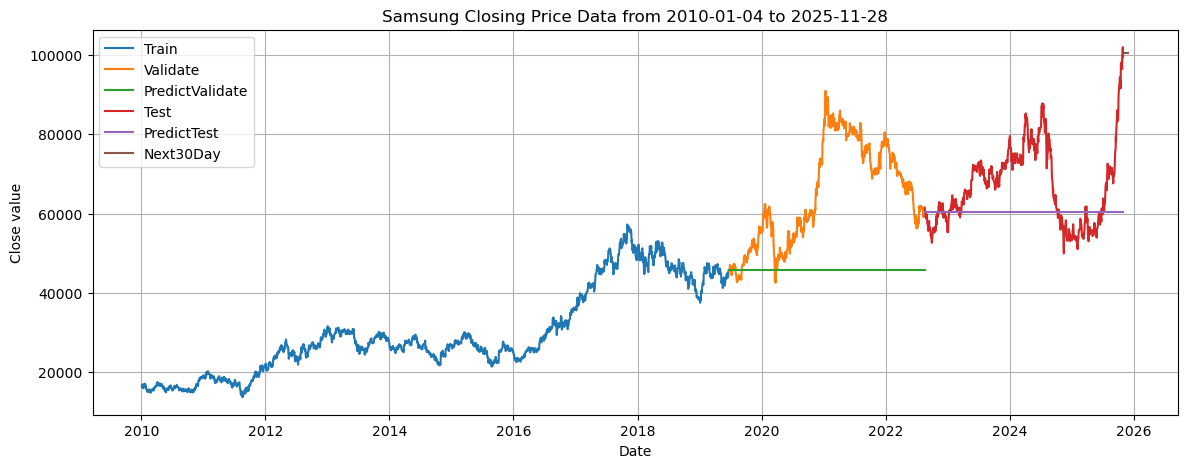

In [15]:
# Cell 15: Visualization
plt.figure(figsize=(14,5))

plt.plot(df.index[:train_size], train_plot, label='Train')
plt.plot(df.index[train_size: train_size + val_size], val_plot, label='Validate')
plt.plot(df.index[train_size: train_size + val_size], pred_val_plot, label='PredictValidate')
plt.plot(df.index[train_size + val_size : train_size + val_size + len(test_plot)], test_plot, label='Test')
plt.plot(df.index[train_size + val_size : train_size + val_size + len(pred_test_plot)], pred_test_plot, label='PredictTest')
plt.plot(index_next_30_days, next30_plot, label='Next30Day')

plt.legend(['Train','Validate','PredictValidate','Test','PredictTest','Next30Day'])
plt.grid()
plt.title(f"Samsung Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('ETS_622_Samsung.png')
plt.show()
